# DIFFUSION MODEL
> Created Nov. 2024 <br>
> Nikhil Bisht<br>

# Definitions

In [1]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from ddpm_conditional import *

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
IMAGEDATA = './image_data.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 64

TARGET = ['Vx_f', 'Vy_f', 'Vz_f','Density_f']
POS_FEAT = ['X_f', 'Y_f', 'Z_f','X_i', 'Y_i', 'Z_i']
FEATURES = ['Vx_i', 'Vy_i', 'Vz_i','Density_i']

FRAMES = [0,125]

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


# Functions

In [2]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def get_data(args, input_arr, labels):
    dataset = TensorDataset(input_arr, labels)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

    
def plot_data(d, filename='xy_data.png'):

    x1, x2 = d[:, 0], d[:, 1]
    xmin, xmax = min(x1), max(x1)
    ymin, ymax = min(x2), max(x2)
    
    fig = plt.figure(figsize=(13, 4))
    fig.tight_layout()
    
    ax  = fig.add_subplot(1, 3, 1)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$x_1$')
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$x_2$')
    
    ax.scatter(x1, x2, s=0.5, color='steelblue', alpha=0.4)

    ax.grid('both')

    ax2  = fig.add_subplot(1, 3, 2)
    ax2.set_xlim(xmin, xmax)
    ax2.set_xlabel(r'$x_1$')
    ax2.set_ylim(0, 0.5)
    
    c, x, _ = ax2.hist(x1, range=(xmin, xmax), bins=100, density=True, 
                       color='steelblue', alpha=0.4)
    x = (x[1:]+x[:-1])/2
    h = x[1]-x[0]
    y = st.norm.pdf(x)
    ax2.plot(x, y, color='red')

    ax3  = fig.add_subplot(1, 3, 3)
    ax3.set_xlim(ymin, ymax)
    ax3.set_xlabel(r'$x_2$')
    ax3.set_ylim(0, 0.5)
    
    c, x, _ = ax3.hist(x2, range=(ymin, ymax), bins=100, density=True, 
                       color='steelblue', alpha=0.4)
    x = (x[1:]+x[:-1])/2
    h = x[1]-x[0]
    y = st.norm.pdf(x)
    ax3.plot(x, y, color='red')
    
    if filename:
        plt.savefig(filename)
        
    plt.show()

# Load Sample

117364
                  X_0       Y_0       Z_0     X_125     Y_125     Z_125
Particle_id                                                            
1405         0.480469  0.167969  0.003906  0.599282  0.197935  0.896923
1488         0.128906  0.183594  0.003906  0.990821  0.345530  0.983217
1489         0.136719  0.183594  0.003906  0.990181  0.348356  0.985088
1490         0.144531  0.183594  0.003906  0.990190  0.348365  0.984724
1531         0.464844  0.183594  0.003906  0.598342  0.199216  0.898427
(117364, 2)


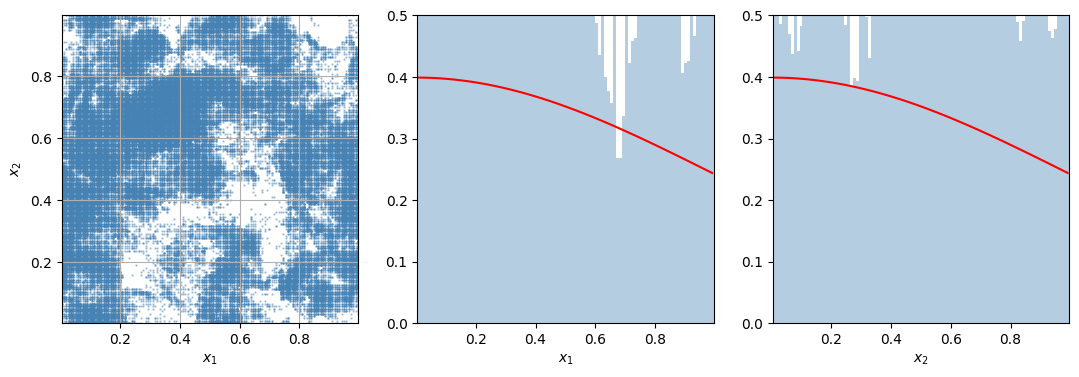

(117364, 2)


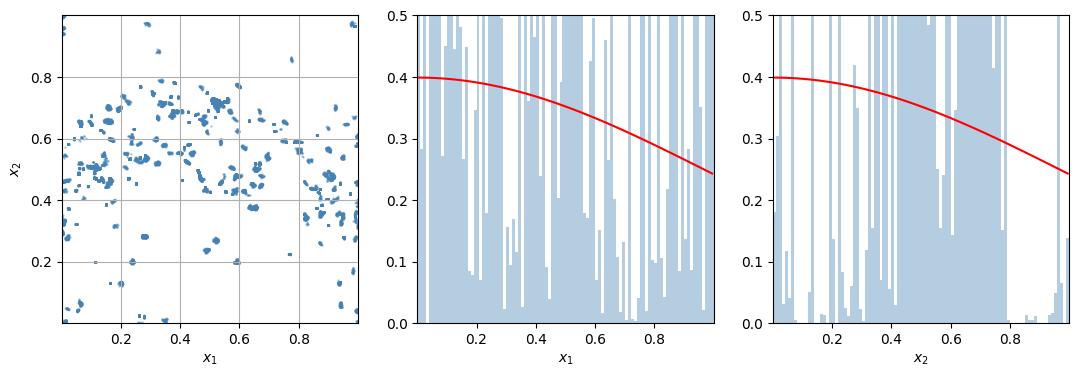

In [3]:
#get data and prepare sample
df_timeseries = pd.DataFrame([])
f =  h5py.File(DATAFILE, 'r')
for frame_num in FRAMES:
    for cname in ['X', 'Y', 'Z']:
        column_name = cname+"_"+str(frame_num)
        f_frame = f[str(frame_num)]
        if frame_num == 0:
            df_timeseries['Particle_id'] = f_frame['Particle_id'][()]
            df_timeseries['Particle_id'] = df_timeseries['Particle_id'].astype('int32')
            df_timeseries[column_name] = f_frame[cname][()]
            df_timeseries = df_timeseries.set_index('Particle_id')
        else:
            appended_series = pd.Series(f_frame[cname][()], index=np.array(f_frame['Particle_id'][()], dtype=int), name = column_name)
            df_timeseries.insert(len(df_timeseries.columns), column_name, appended_series)

f.close()

#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#Now we split noncore and core
df_timeseries_core = df_timeseries.loc[df_core_pids]
df_timeseries_noncore = df_timeseries.drop(df_core_pids)

print(len(df_timeseries_core))
print(df_timeseries_core.head())
initial_dataset_core = df_timeseries_core[['X_0', 'Y_0']].to_numpy()
final_dataset_core = df_timeseries_core[['X_125', 'Y_125']].to_numpy()
print(initial_dataset_core.shape)
plot_data(initial_dataset_core, "initial_core_xy_data.png")
print(final_dataset_core.shape)
plot_data(final_dataset_core, "final_core_xy_data.png")

check_initial.jpg


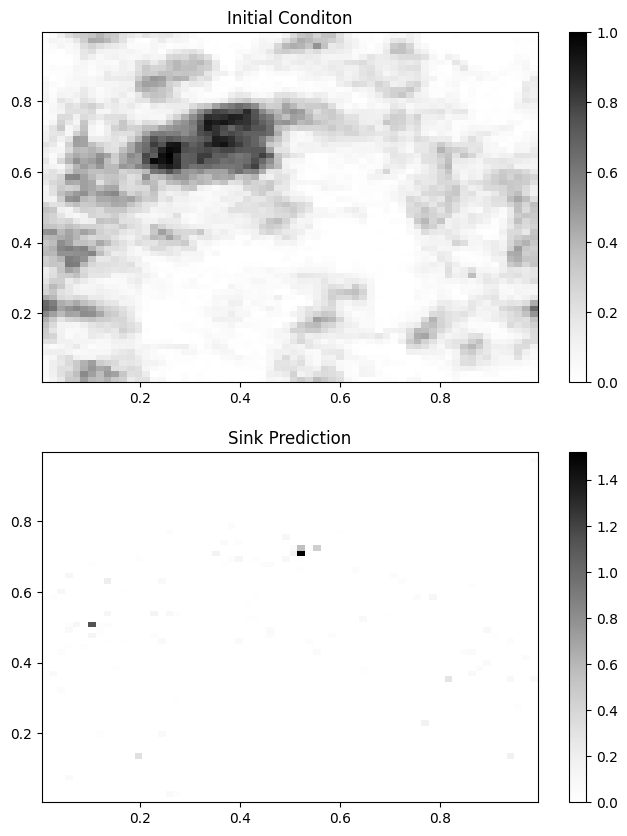

In [4]:
#bin numpy array to a 64x64 histogram
num  = 0
H_initial, edges = np.histogramdd(initial_dataset_core, bins = (IMAGESIZE, IMAGESIZE))
H_final, edges = np.histogramdd(final_dataset_core, bins = edges)
#Scale to (0,255), RGB values
initial_scalor = max(map(max, H_initial))
H_final = (H_final/(initial_scalor*IMAGESIZE)) #test with and without IMAGESIZE
H_initial = (H_initial/initial_scalor)
H = np.array([H_initial, H_final])
save_images(np.array([H]), edges, "check_initial.jpg")
rewrite = 1
if rewrite == 1:
    h5f = h5py.File(IMAGEDATA, 'w')
    h5f.create_dataset('img_'+str(num), data=H)
    h5f.create_dataset('imgedges_'+str(num), data=edges)
    h5f.create_dataset('imgscalor_'+str(num), data=initial_scalor)
    h5f.close()
if rewrite == 0 and os.path.isfile(IMAGEDATA):
    print("File exists!")

noise_conditional.jpg


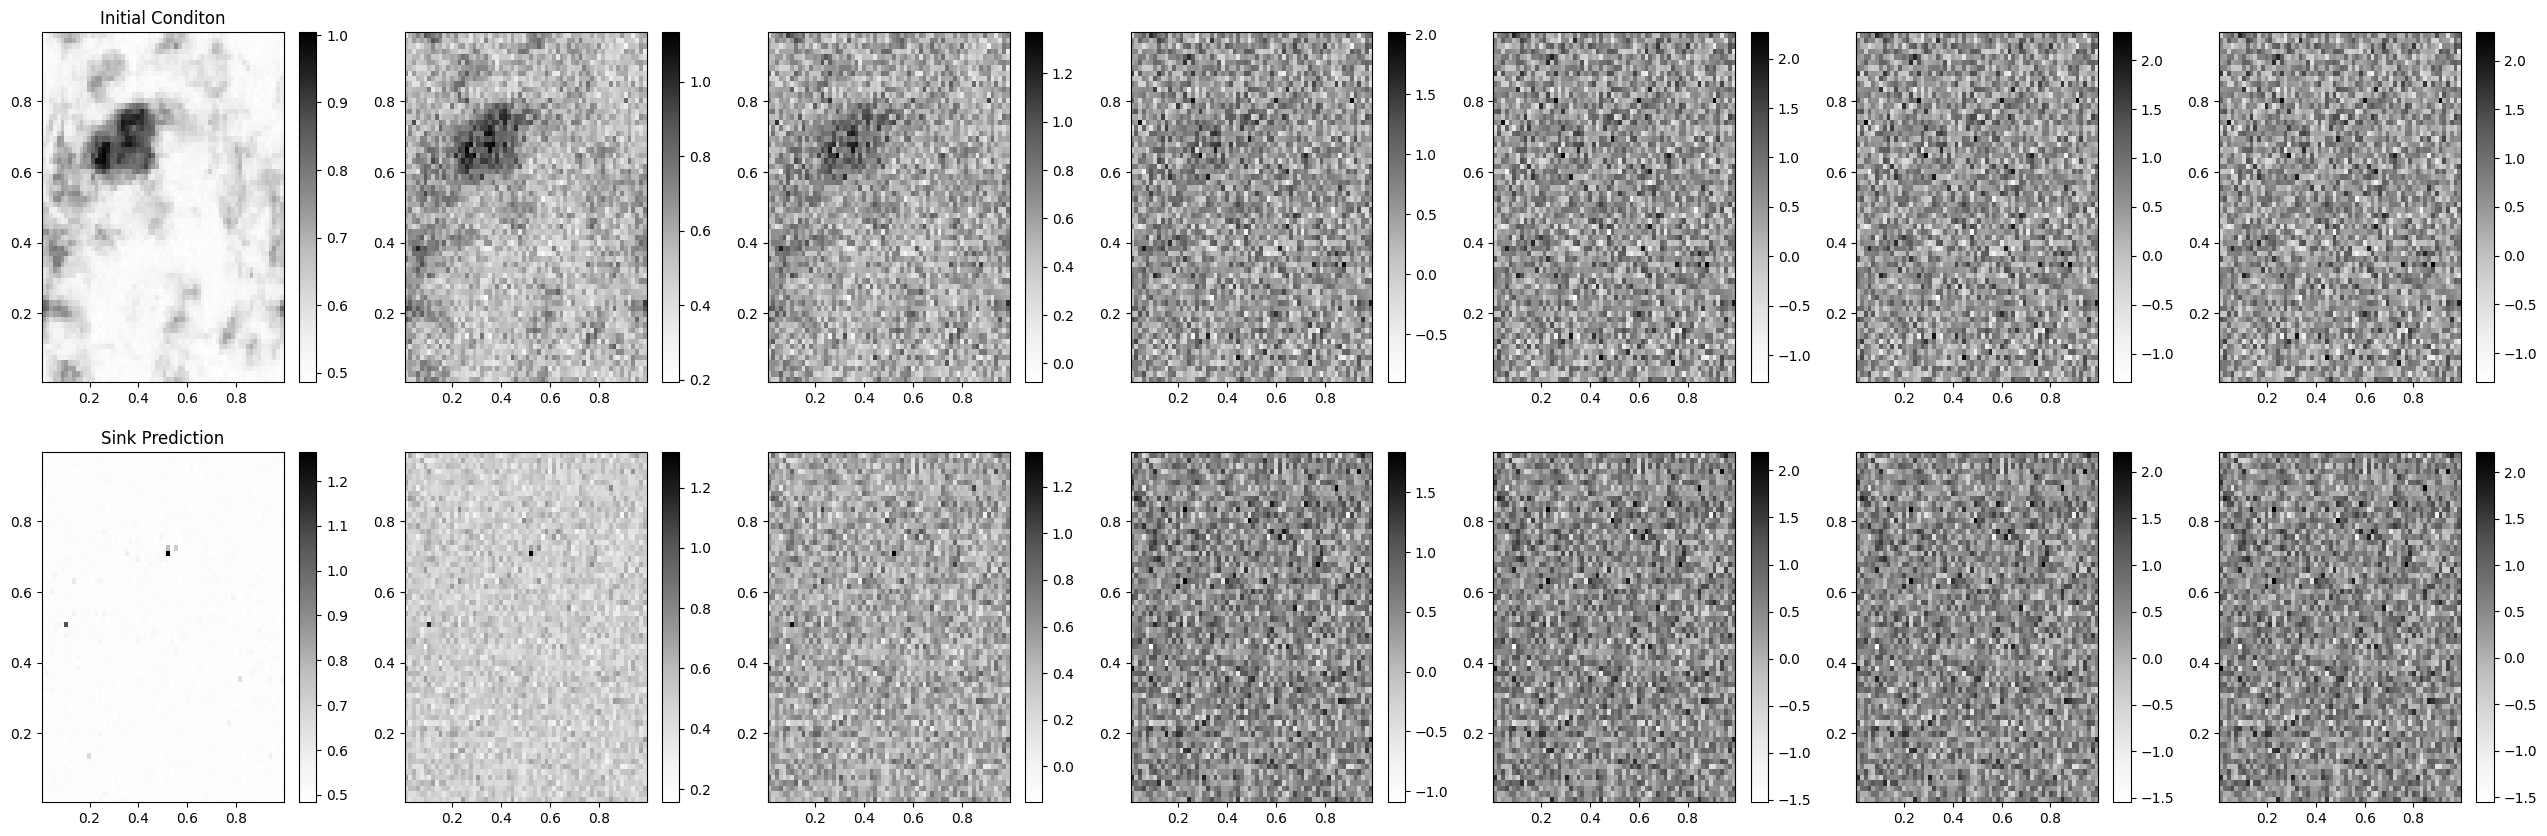

torch.Size([1, 2, 64, 64])

In [5]:
image_arr = []
h5f = h5py.File(IMAGEDATA,'r')
labels = []
edges_IC = []
scalor_IC = []
for num in range(int(len(h5f.keys())/3)):
    H = h5f['img_'+str(num)][:]
    H = H.astype(np.float32)
    image_arr.append(H)
    edges_arr = h5f['imgedges_'+str(num)][:]
    edges_IC.append(edges_arr)
    scalor_init = h5f['imgscalor_'+str(num)]
    scalor_IC.append(scalor_init)
    labels.append(torch.tensor(num))
h5f.close()
#noising test

parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.batch_size = 1  # 5
args.image_size = IMAGESIZE
args.dataset_path = IMAGEDATA
args.device = DEVICE

dataloader = get_data(args, torch.tensor(np.array(image_arr)), torch.tensor(np.array(labels)))

diff = Diffusion(device="cpu")

image = next(iter(dataloader))[0]
t = torch.Tensor([0, 50, 100, 300, 600, 700, 999]).long()

noised_image, _ = diff.noise_images(image, t)
save_images(noised_image.add(1).mul(0.5), edges_IC[0], "noise_conditional.jpg")
image.shape

03:08:19 - INFO: Starting epoch 0:
100%|██████████| 1/1 [00:00<00:00,  3.60it/s, MSE=1.7]
03:08:19 - INFO: Sampling 1 new images....
999it [01:22, 12.17it/s]
03:09:41 - INFO: Sampling 1 new images....
999it [01:23, 12.03it/s]


results/DDPM_conditional/0.jpg


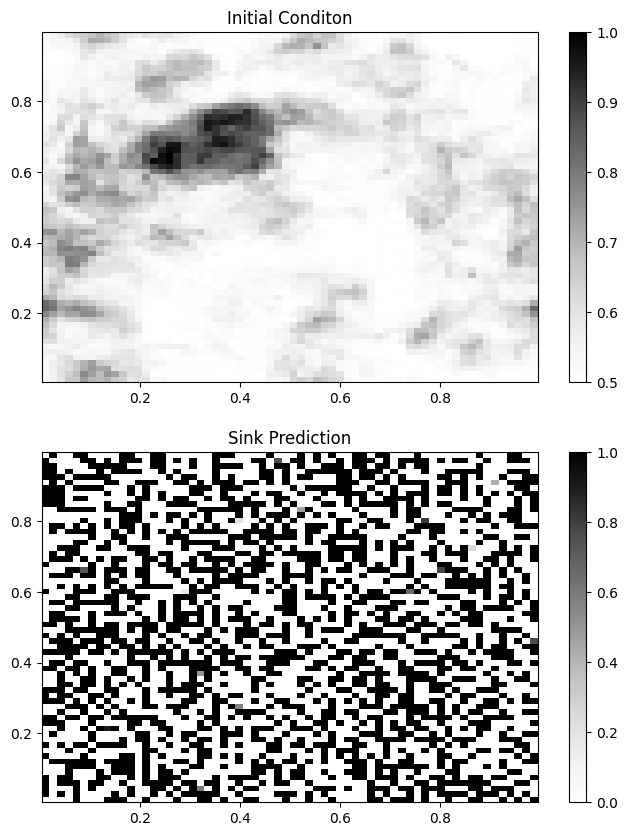

results/DDPM_conditional/0_ema.jpg


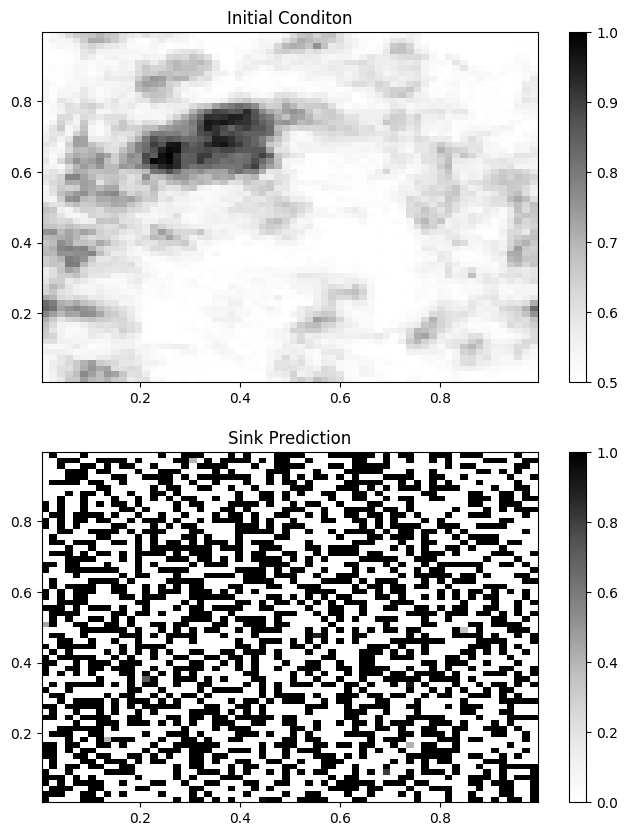

03:11:05 - INFO: Starting epoch 1:
100%|██████████| 1/1 [00:00<00:00,  3.55it/s, MSE=2.75]


In [7]:
#launch training
args.run_name = "DDPM_conditional"
args.epochs = 2
args.batch_size = 1
args.channel = 2
args.image_size = IMAGESIZE
args.dataset_path = IMAGEDATA
args.device = DEVICE
args.lr = 3e-4
args.noise_steps = 1000
train(args,dataloader, edges = edges_IC[0])

## Stats
- x1 == Gaussian distribution; N = 8000; B = 16000
    - T = 10
        - $FID: 2.4463259683877026e-03; KS: [0.1693125 0.2083125]; P-value: [4.05985932e-134 1.79622800e-203]$

